In [1]:
# import libraries and datasets
import numpy as np
import h5py
import json
from matplotlib import pyplot as plt
from scipy import signal
from scipy import ndimage as nd
%matplotlib inline

directory = 'LOSC_Event_tutorial\\'

filenames_H = ['H-H1_LOSC_4_V2-1126259446-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5',
               'H-H1_LOSC_4_V1-1167559920-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5']
filenames_L = ['L-L1_LOSC_4_V2-1126259446-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5',
               'L-L1_LOSC_4_V1-1167559920-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5']
templatenames = ['GW150914_4_template.hdf5', 'GW151226_4_template.hdf5',
                 'GW170104_4_template.hdf5', 'LVT151012_4_template.hdf5']

def print_data_mapping(): # json mapping template to filenames
    data_mapping = open(directory + "BBH_events_v3.json")
    data_mapping_parsed = json.load(data_mapping)
    print(json.dumps(data_mapping_parsed, indent=2, sort_keys=True))
# print_data_mapping()
    
def print_attrs(name): # display h5py keys and values
    print(name)
#data.visit(print_attrs)

def detector_strain_events(filenames):
    strain_detector=[]
    for filename in filenames:
        data_tmp = h5py.File(directory+filename, 'r')
        strain_tmp = data_tmp['strain/Strain'].value
        strain_detector.append(strain_tmp)
    return strain_detector

def detector_dt_events(filenames):
    dt_detector=[]
    for filename in filenames:
        data_tmp = h5py.File(directory+filename, 'r')
        dt = data_tmp['strain']['Strain'].attrs['Xspacing']
        dt_detector.append(dt)
    return dt_detector

strain_H = detector_strain_events(filenames_H)
dt_H = detector_dt_events(filenames_H)

strain_L = detector_strain_events(filenames_L)
dt_L = detector_dt_events(filenames_L)

C:\Users\ngren\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [2]:
def noise_model(strain, dt, filter_order=1):
    
    window = signal.tukey(len(strain), alpha=0.5)
    norm_fac = np.sqrt(np.mean(window**2))
    
    strain_fft = np.fft.rfft(strain * window)**2
    
    power = np.absolute(strain_fft/norm_fac)
    freqs = np.fft.rfftfreq(len(strain), dt) 
    power_smooth = nd.gaussian_filter1d(power, filter_order)

    return power_smooth, freqs

In [3]:
def detector_strain_noiseModels(strains, dts):
    noises=[]
    freqs=[]
    for (strain, dt) in zip(strains, dts):
        strain_noise, freqs_tmp = noise_model(strain, dt)
        noises.append(strain_noise)
        freqs.append(freqs_tmp)
    return noises, freqs

noise_H, freqs_H = detector_strain_noiseModels(strain_H, dt_H)
noise_L, freqs_L = detector_strain_noiseModels(strain_L, dt_L)

In [4]:
def plot_event_noise(ax, freqs_H, freqs_L, noise_H, noise_L, title='Event Noise',
                    xlabel='frequencies (Hz)', ylabel='strain', f_min = 20, f_max = 2048): # 2048 niquist frequency
    ax.loglog(freqs_H, noise_H, '-r', markersize='0.5', label="Hanford")
    ax.loglog(freqs_L, noise_L, '-g', markersize='0.5', label="Livingston")
    ax.axis([f_min, f_max, 1e-42, 1e-29])
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

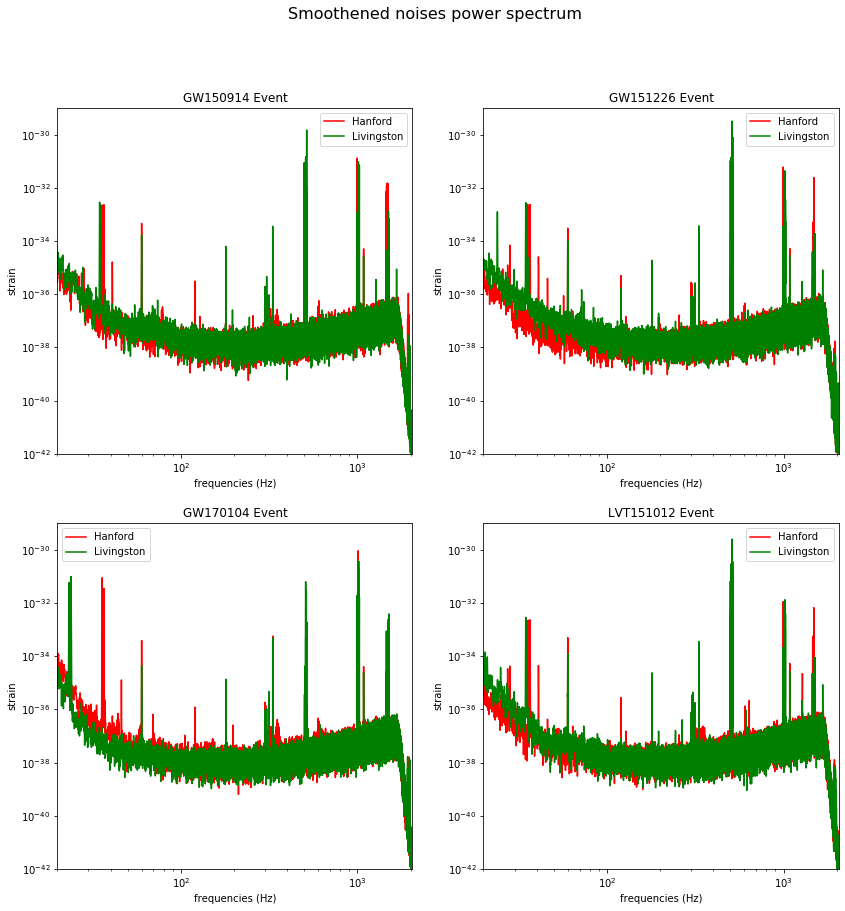

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(14,14))
fig.suptitle('Smoothened noises power spectrum', fontsize=16)
plot_event_noise(axs[0,0], freqs_H[0], freqs_L[0], noise_H[0], noise_L[0], title='GW150914 Event')
plot_event_noise(axs[0,1], freqs_H[1], freqs_L[1], noise_H[1], noise_L[1], title='GW151226 Event')
plot_event_noise(axs[1,0], freqs_H[2], freqs_L[2], noise_H[2], noise_L[2], title='GW170104 Event')
plot_event_noise(axs[1,1], freqs_H[3], freqs_L[3], noise_H[3], noise_L[3], title='LVT151012 Event')

plt.savefig("figures/noises_smooth.png")
plt.show()

In [6]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

templates_H=[]
templates_L=[]
for template_name in templatenames:
    template = read_template(directory+template_name)
    templates_H.append(template[0])
    templates_L.append(template[1])

In [7]:
def matched_filter(strain, template, noise):
    
    window_s = signal.tukey(len(strain), alpha=0.5)
    strain_fft = np.fft.rfft(strain*window_s)
    rhs = strain_fft
    
    window_t = signal.tukey(len(template), alpha=0.5)
    template_fft = np.fft.rfft(template*window_t)
    lhs = np.transpose(np.conjugate(template_fft/noise))
    
    matched_filter = np.fft.irfft(lhs*rhs)
    return matched_filter

In [8]:
mf_H = []
for (strain, template, noise) in zip(strain_H, templates_H, noise_H):
    mf_H.append(matched_filter(strain, template, noise))

mf_L = []
for (strain, template, noise) in zip(strain_L, templates_L, noise_L):
    mf_L.append(matched_filter(strain, template, noise))

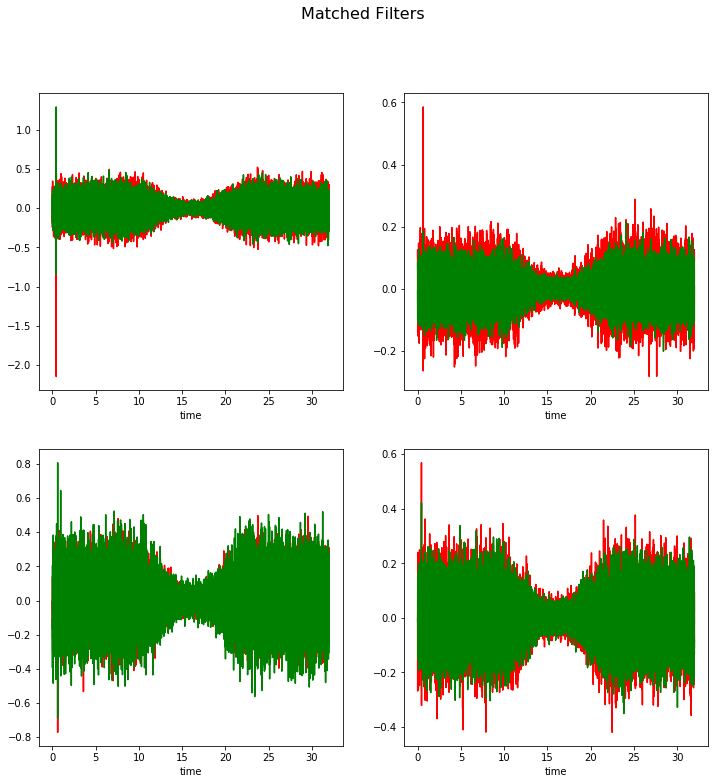

In [9]:
def plot_matched_filter(ax, time, mf_H, mf_L, title='',
                    xlabel='time', ylabel=''):
    ax.plot(time, mf_H, '-r', markersize='0.5')
    ax.plot(time, mf_L, '-g', markersize='0.5')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

time = np.arange(0, len(strain_H[0])*dt_H[0], dt_H[0])

fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Matched Filters', fontsize=16)
plot_matched_filter(axs[0,0], time, mf_H[0], mf_L[0])
plot_matched_filter(axs[0,1], time, mf_H[1], mf_L[1])
plot_matched_filter(axs[1,0], time, mf_H[2], mf_L[2])
plot_matched_filter(axs[1,1], time, mf_H[3], mf_L[3])
plt.show()

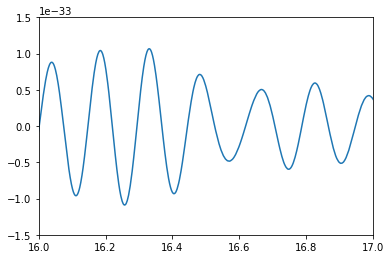

In [10]:
# convolve filter with data
window_s = signal.tukey(len(strain_H[3]), alpha=0.5)
strain_fft = np.fft.rfft(strain_H[3]*window_s)

window_mf = signal.tukey(len(mf_H[3]), alpha=0.5)
mf_fft = np.fft.rfft(strain_H[3]*window_mf)

output = strain_fft*mf_fft
output = np.fft.irfft(output)

plt.plot(time, output)
plt.axis([16, 17, -1.5e-33, 1.5e-33])
plt.show()